# Energy imbalance in the ocean
Andrew Delman. Updated 2025-05-24.

This tutorial covers the ocean's role in the Earth's energy imbalance, as depicted in the ECCO state estimate. The two ECCO releases v4r4 and v4r5 are analyzed and compared.

```{note}
This tutorial should be run on a server/instance with a minimum of 32 GB RAM for good performance.
```

## Objectives

- Quantify the ocean heat content (OHC) change
- Quantify heat fluxes entering the ocean through the surface, as well as the geothermal flux
- Compute time mean and trends in OHC change and heat fluxes, and consider implications for the ocean's energy imbalance

## Introduction

The [Earth's energy imbalance (EEI)](https://wmo.int/media/news/new-study-shows-earth-energy-imbalance) is a key indicator of changes in Earth's air temperature and climate. The atmospheric temperature change is the net flux of radiative energy through the top of the atmosphere, minus the heat fluxes to the oceans, land, and cryosphere (ice). Of the heat stored as a result of EEI, one recent study [(von Schuckmann et al. 2023)](https://essd.copernicus.org/articles/15/1675/2023/) estimated that ~89% has accumulated in the oceans. Therefore closing the Earth's energy budget requires an accurate estimate heat storage in the ocean, and how much of that storage is the result of fluxes atmosphere->ocean vs. from other sources.

There are two ways to estimate the ocean's energy imbalance from observations: (1) by observing the temperature change in the ocean directly, and (2) by observing the fluxes of heat into the ocean. Since the uncertainties of the data products are significant relative to the signal of the energy imbalance itself, being able to use both methods is important for constraining estimates of energy imbalance and lowering uncertainties.

## Ocean heat content change

First, let's quantify the OHC change using ECCO. Note that these computations are an abbreviated version of this ECCO [heat budget tutorial](https://ecco-v4-python-tutorial.readthedocs.io/ECCO_v4_Heat_budget_closure.html). In this case we do not quantify heat advection and diffusion within the ocean, since we are only concerned with the global OHC change, rather than heat redistribution within the ocean.

The code below computes the total temperature tendency in the ocean (vertical mean), as well as the contribution of "forcing" to the tendency. In this case "forcing" is the heat flux through the ocean surface from the atmosphere and sea-ice, as well as the geothermal flux through the ocean floor.

In [1]:
# import needed packages
import numpy as np
import xarray as xr
import dask.array
import glob
import matplotlib.pyplot as plt
import requests

from os.path import expanduser,join,exists
import sys
user_home_dir = expanduser('~')
sys.path.insert(0,join(user_home_dir,'ECCOv4-py'))
import ecco_v4_py as ecco
import ecco_v4_py.ecco_access as ea



def geoflx_retrieve(ecco_grid,geoflx_dir=join(user_home_dir,'Downloads')):
    """Retrieve geothermal flux data and load into workspace"""
    
    # Make copy of hFacC
    mskC = ecco_grid.hFacC.copy(deep=True).compute()
    
    # Change all fractions (ocean) to 1. land = 0
    mskC.values[mskC.values>0] = 1

    geoflx_filename = join(geoflx_dir,'geothermalFlux.bin')
    if not exists(geoflx_filename):
        # Load the geothermal heat flux using the routine 'read_llc_to_tiles'.
        r = requests.get(\
                'https://github.com/ECCO-GROUP/ECCO-v4-Python-Tutorial/raw/refs/heads/master/misc/geothermalFlux.bin')
    
        # save geothermal flux to file in local directory geoflx_dir
        geoflx_filename = join(geoflx_dir,'geothermalFlux.bin')
        with open(geoflx_filename,'wb') as f:
            for chunk in r.iter_content(chunk_size=1024):
                f.write(chunk)
    
    
    geoflx = ecco.read_llc_to_tiles(geoflx_dir, 'geothermalFlux.bin')
    # Convert numpy array to an xarray DataArray with matching dimensions as the monthly mean fields
    geoflx_llc = xr.DataArray(geoflx,coords={'tile': ecco_grid.tile.values,
                                             'j': ecco_grid.j.values,
                                             'i': ecco_grid.i.values})
    # Create 3d bathymetry mask
    mskC_shifted = mskC.shift(k=-1)
    
    mskC_shifted.values[-1,:,:,:] = 0
    mskb = mskC - mskC_shifted
    
    # Create 3d field of geothermal heat flux
    geoflx3d = geoflx_llc * mskb.transpose('k','tile','j','i')
    GEOFLX = geoflx3d.transpose('k','tile','j','i')
    GEOFLX.attrs = {'standard_name': 'GEOFLX','long_name': 'Geothermal heat flux','units': 'W/m^2'}

    return GEOFLX
    

def temp_tend_forcing_vertmean_compute(version='v4r4',StartDate='1992-01',EndDate='2017-12'):
    """Compute vertical mean of total temperature tendency
       and forcing (surface flux & geothermal) contribution.
       Computation can be done with v4r4 or v4r5 output;
       v4r4 temperature tendency is computed using snapshots at month boundaries, 
       while v4r5 temperature tendency is computed using interpolation
       from monthly mean data."""

    # Seawater density (kg/m^3)
    rhoconst = 1029
    ## needed to convert surface mass fluxes to volume fluxes
    
    # Heat capacity (J/kg/K)
    c_p = 3994
    
    # Constants for surface heat penetration (from Table 2 of Paulson and Simpson, 1977)
    R = 0.62
    zeta1 = 0.6
    zeta2 = 20.0
    
    
    # ShortNames
    if version == 'v4r4':
        
        ## access datasets needed for this tutorial
        
        ShortNames_list = ["ECCO_L4_HEAT_FLUX_LLC0090GRID_MONTHLY_V4R4",\
                           "ECCO_L4_FRESH_FLUX_LLC0090GRID_MONTHLY_V4R4",\
                           "ECCO_L4_TEMP_SALINITY_LLC0090GRID_MONTHLY_V4R4",\
                           "ECCO_L4_SSH_LLC0090GRID_SNAPSHOT_V4R4",\
                           "ECCO_L4_TEMP_SALINITY_LLC0090GRID_SNAPSHOT_V4R4"]
        
        access_mode = 's3_open_fsspec'
        # for access_mode = 's3_open_fsspec', need to specify the root directory 
        # containing the jsons
        jsons_root_dir = join('/efs_ecco','mzz-jsons')
        
    elif version == 'v4r5':
        # note that in v4r5 we need to include the vertical heat flux under ice shelves
        # (this is not a term in v4r4)
        ShortNames_list = ["ECCO_L4_OCEAN_AND_ICE_SURFACE_HEAT_FLUX_LLC0090GRID_MONTHLY_V4R5",\
                           "ECCO_L4_OCEAN_AND_ICE_SURFACE_FW_FLUX_LLC0090GRID_MONTHLY_V4R5",\
                           "ECCO_L4_OCEAN_TEMPERATURE_SALINITY_LLC0090GRID_MONTHLY_V4R5",\
                           "ECCO_L4_ICE_SHELF_FLUX_LLC0090GRID_MONTHLY_V4R5",\
                           "ECCO_L4_ICE_FRONT_FLUX_LLC0090GRID_MONTHLY_V4R5",\
                           "ECCO_L4_SEA_SURFACE_HEIGHT_LLC0090GRID_SNAPSHOT_V4R5",\
                           "ECCO_L4_OCEAN_TEMPERATURE_SALINITY_LLC0090GRID_SNAPSHOT_V4R5"]
    
        access_mode = 's3_open_fsspec'
        # for access_mode = 's3_open_fsspec', need to specify the root directory 
        # containing the jsons
        jsons_root_dir = join('/efs_ecco','mzz-jsons-V4r5')
        
    
    # load grid parameters
    if version == 'v4r4':
        ecco_grid = ea.ecco_podaac_to_xrdataset("ECCO_L4_GEOMETRY_LLC0090GRID_V4R4",\
                                                  version='v4r4',\
                                                  mode=access_mode,\
                                                  jsons_root_dir=jsons_root_dir)
    elif version == 'v4r5':
        ecco_grid = xr.open_dataset(\
            '/efs_ecco/ECCO/V4/r5/netcdf/native/geometry/GRID_GEOMETRY_ECCO_V4r5_native_llc0090.nc')
    ecco_grid = ecco_grid.compute()
    
    ds_dict = ea.ecco_podaac_to_xrdataset(ShortNames_list,\
                                                StartDate=StartDate,EndDate=EndDate,\
                                                version=version,\
                                                snapshot_interval='monthly',\
                                                mode=access_mode,\
                                                jsons_root_dir=jsons_root_dir,\
                                                show_noredownload_msg=False,\
                                                prompt_request_payer=False)

    
    # Volume (m^3)
    vol = (ecco_grid.rA*ecco_grid.drF*ecco_grid.hFacC).transpose('tile','k','j','i').compute()
    
    year_start = np.int64(StartDate[:4])
    year_end = np.int64(EndDate[:4])
    
    
    # open ETAN and THETA snapshots (beginning of each month)
    
    ecco_monthly_SSH = ds_dict[ShortNames_list[-2]]
    ecco_monthly_TS = ds_dict[ShortNames_list[-1]]
    ecco_monthly_snaps = xr.merge((ecco_monthly_SSH['ETAN'],ecco_monthly_TS['THETA']))
        
    # time mask for snapshots
    time_snap_mask = np.logical_and(ecco_monthly_snaps.time.values >= np.datetime64(str(year_start)+'-01-01','ns'),\
                                    ecco_monthly_snaps.time.values < np.datetime64(str(year_end+1)+'-01-02','ns'))
    
    ecco_monthly_snaps = ecco_monthly_snaps.isel(time=time_snap_mask)

    
    ## Consolidate ECCO monthly mean variables needed into one dataset
    
    ecco_vars_sfc = ds_dict[ShortNames_list[0]]
    ecco_vars_sfcFW = ds_dict[ShortNames_list[1]]
    ecco_vars_TS = ds_dict[ShortNames_list[2]]
    
    ecco_monthly_mean = xr.merge((ecco_vars_sfc[['TFLUX','oceQsw','oceQnet']],\
                                  ecco_vars_sfcFW['oceFWflx'],\
                                  ecco_vars_TS['THETA']))

    if version == 'v4r5':
        ecco_vars_iceshelf_flux = ds_dict[ShortNames_list[3]]
        ecco_vars_icefront_flux = ds_dict[ShortNames_list[4]]
        ecco_monthly_mean = xr.merge((ecco_monthly_mean,\
                                      ecco_vars_iceshelf_flux['SHIhtFlx'],\
                                      ecco_vars_icefront_flux['ICFhtFlx']))
    
    # time mask for monthly means
    time_mean_mask = np.logical_and(ecco_monthly_mean.time.values >= np.datetime64(str(year_start)+'-01-01','ns'),\
                                    ecco_monthly_mean.time.values < np.datetime64(str(year_end+1)+'-01-01','ns'))
    
    ecco_monthly_mean = ecco_monthly_mean.isel(time=time_mean_mask)
    
    
    # Drop superfluous coordinates, 
    # but keep time_bnds for padding the beginning and end of snapshot dataset
    ecco_monthly_mean = ecco_monthly_mean.reset_coords(drop=True)
    ecco_monthly_mean = ecco_monthly_mean.assign_coords(time_bnds=ecco_vars_TS.time_bnds)

    # pad time axis of snapshot dataset as needed
    if ecco_monthly_snaps.sizes['time'] <= ecco_monthly_mean.sizes['time']:
        n_pad_end = ecco_monthly_mean.sizes['time'] - ecco_monthly_snaps.sizes['time']
        ecco_monthly_snaps = ecco_monthly_snaps.pad(pad_width={'time':(1,n_pad_end)},mode='constant',\
                                                    constant_values=np.nan)
        # fill in time bounds of monthly means even where snapshot data is missing 
        ecco_monthly_snaps.time.data[0] = ecco_monthly_mean.time_bnds[0,0].values
        ecco_monthly_snaps.time.data[-n_pad_end:] = ecco_monthly_mean.time_bnds[-n_pad_end:,1].values

    # merge all datasets into one
    ds = xr.merge([ecco_monthly_mean,\
                   ecco_monthly_snaps.rename({'time':'time_snp','ETAN':'ETAN_snp', 'THETA':'THETA_snp'}),\
                   ecco_grid[['hFacC','drF','rA']]])
    
    # Change time axis of the snapshot variables
    ds.time_snp.attrs['c_grid_axis_shift'] = 0.5
    
    # get LLC grid object
    grid = ecco.get_llc_grid(ds)
    
    
    
    ## compute vertical mean temperature tendency
    
    delta_t = xr.DataArray(np.diff(ds.time_snp.data),coords={'time':ds.time})
    
    # Convert to seconds
    delta_t = delta_t.astype('f4') / 1e9
    
    
    # Calculate the s*theta term
    sTHETA = ds.THETA_snp*(1+ds.ETAN_snp/ecco_grid.Depth)
    
    
    # Total tendency (psu/s)
    G_total = sTHETA.diff(dim='time_snp')/np.expand_dims(delta_t.values,axis=(1,2,3,4))
    
    # re-assign and rename time coordinate
    G_total = G_total.rename({'time_snp':'time'})
    G_total = G_total.assign_coords({'time':delta_t.time.values})

    # vertical mean of G_total
    depth_int_masked = (ds.hFacC*ds.drF).compute()
    
    G_total_vertmean = (((depth_int_masked*G_total).sum('k'))/\
                          (depth_int_masked.sum('k')))\
                            .transpose('time','tile','j','i').compute()
    G_total_vertmean = G_total_vertmean.where(np.abs(G_total_vertmean) > 1.e-16,np.nan)
    
    
    # The weights are just the number of seconds per month divided by total seconds
    month_length_weights = delta_t / delta_t.sum()    

    print('Total temp tend computed,',version)

    
    ## compute forcing flux
    def forcH_compute(ds,ecco_grid):
        
        Z = ecco_grid.Z
        RF = np.concatenate([ecco_grid.Zp1.values[:-1],[np.nan]])
        
        q1 = R*np.exp(1.0/zeta1*RF[:-1]) + (1.0-R)*np.exp(1.0/zeta2*RF[:-1])
        q2 = R*np.exp(1.0/zeta1*RF[1:]) + (1.0-R)*np.exp(1.0/zeta2*RF[1:])
        
        # Correction for the 200m cutoff
        zCut = np.where(Z < -200)[0][0]
        q1[zCut:] = 0
        q2[zCut-1:] = 0
        
        # Create xarray data arrays
        q1 = xr.DataArray(q1,coords=[Z.k],dims=['k'])
        q2 = xr.DataArray(q2,coords=[Z.k],dims=['k'])
        
        # ## Land masks
        # # Make copy of hFacC
        # mskC = ecco_grid.hFacC.copy(deep=True).compute()
        
        # # Change all fractions (ocean) to 1. land = 0
        # mskC.values[mskC.values>0] = 1

        mskC = ecco_grid.maskC.copy(deep=True).astype('float32')
        
        # Shortwave flux below the surface (W/m^2)
        oceQsw = ds.oceQsw.compute()
        forcH_subsurf = ((q1*(mskC==1)-q2*(mskC.shift(k=-1)==1))*oceQsw).transpose('time','k','tile','j','i')

        # in version v4r5, we also need the (subsurface) heat flux between the ocean and the ice shelves
        if version == 'v4r5':
            # # vertical heat flux between ocean and ice shelf
            # mask for ice-ocean boundary across top face of grid cells
            ice_ocean_bound_mask_k_l = mskC.diff('k')\
                                        .pad(pad_width={'k':(1,0)},mode='constant',constant_values=0)
            # drop coordinates (to avoid complications from coordinates not updating)
            # and rename vertical dimension
            ice_ocean_bound_mask_k_l = ice_ocean_bound_mask_k_l.reset_coords(drop=True).rename({'k':'k_l'})
            ice_ocean_bound_mask_k_l['k_l'] = np.arange(0,ds.sizes['k'])
            # exclude bottom bathymetry from mask
            ice_ocean_bound_mask_k_l = ice_ocean_bound_mask_k_l.where(ice_ocean_bound_mask_k_l >=0,0)
            ice_shelf_hflux_3d_k_l = ice_ocean_bound_mask_k_l*(-ds.SHIhtFlx)
            forcH_ice_shelf_3d = ice_shelf_hflux_3d_k_l.diff('k_l')\
                                    .pad(pad_width={'k_l':(0,1)},mode='constant',constant_values=0)
            forcH_ice_shelf_3d = forcH_ice_shelf_3d.rename({'k_l':'k'})
            forcH_ice_shelf_3d['k'] = np.arange(0,ds.sizes['k'])
            
            # # lateral heat flux between ocean and ice shelf
            forcH_ice_front_3d = -ds.ICFhtFlx

            forcH_subsurf += (forcH_ice_shelf_3d + forcH_ice_front_3d).compute()
            
        
        # Surface heat flux (W/m^2)
        forcH_surf = ((ds.TFLUX.compute() - (1-(q1[0]-q2[0]))*oceQsw)\
                      *mskC[0]).transpose('time','tile','j','i').assign_coords(k=0).expand_dims('k')
        
        # Full-depth sea surface forcing (W/m^2)
        forcH = xr.concat([forcH_surf,forcH_subsurf.isel(k=slice(1,None))],dim='k').transpose('time','k','tile','j','i')
        
        
        return forcH
    
    
    ## vertical mean of forcing tendency    
    
    # Load the geothermal heat flux
    GEOFLX = geoflx_retrieve(ecco_grid)

    
    # compute in chunks in order to limit memory usage

    depth_int_masked = (ds.hFacC*ds.drF).compute()
    
    G_forcing_vertmean_array = np.empty(G_total_vertmean.shape)
    G_forcing_vertmean_array.fill(np.nan)
    t_chunksize = 24
    for chunk in range(0,int(np.ceil(ds.sizes['time']/t_chunksize))):
        curr_t = slice(chunk*t_chunksize,np.fmin((chunk+1)*t_chunksize,ds.sizes['time']))
        # compute surface (and subsurface shortwave) forcing flux
        curr_forcH = forcH_compute(ds.isel(time=curr_t),ecco_grid)
        
        # Add geothermal heat flux to forcing field and convert from W/m^2 to degC/s
        curr_G_forcing = ((curr_forcH + GEOFLX)/(rhoconst*c_p))/(ecco_grid.hFacC*ecco_grid.drF)

        # depth average
        G_forcing_vertmean_array[curr_t,:,:,:] = (((depth_int_masked*curr_G_forcing).sum('k'))/\
                                                      (depth_int_masked.sum('k')))\
                                                        .transpose('time','tile','j','i').values
    G_forcing_vertmean = xr.DataArray(G_forcing_vertmean_array,dims=['time','tile','j','i'],\
                                      coords={'time':ds.time})

    print('Forcing temp tend computed,',version)

    
    return G_total_vertmean,G_forcing_vertmean,ds


G_total_vertmean_v4r4,G_forcing_vertmean_v4r4,ds_v4r4 = \
                        temp_tend_forcing_vertmean_compute(version='v4r4',\
                                                  StartDate='1992-01',EndDate='2017-12')

G_total_vertmean_v4r5,G_forcing_vertmean_v4r5,ds_v4r5 = \
                        temp_tend_forcing_vertmean_compute(version='v4r5',\
                                                  StartDate='1992-01',EndDate='2019-12')

Automatic pdb calling has been turned ON


/srv/conda/envs/notebook/lib/python3.12/site-packages/dask/_task_spec.py:741: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)


Total temp tend computed, v4r4


/tmp/ipykernel_2412/1660150111.py:30: DeprecationWarning: Bitwise inversion '~' on bool is deprecated and will be removed in Python 3.16. This returns the bitwise inversion of the underlying int object and is usually not what you expect from negating a bool. Use the 'not' operator for boolean negation or ~int(x) if you really want the bitwise inversion of the underlying int.
  if ~exists(geoflx_filename):


load_binary_array: loading file /home/jovyan/Downloads/geothermalFlux.bin
load_binary_array: data array shape  (1170, 90)
load_binary_array: data array type  >f4
llc_compact_to_faces: dims, llc  (1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  >f4
Forcing temp tend computed, v4r4


/srv/conda/envs/notebook/lib/python3.12/site-packages/dask/_task_spec.py:741: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)


Total temp tend computed, v4r5


/tmp/ipykernel_2412/1660150111.py:30: DeprecationWarning: Bitwise inversion '~' on bool is deprecated and will be removed in Python 3.16. This returns the bitwise inversion of the underlying int object and is usually not what you expect from negating a bool. Use the 'not' operator for boolean negation or ~int(x) if you really want the bitwise inversion of the underlying int.
  if ~exists(geoflx_filename):


load_binary_array: loading file /home/jovyan/Downloads/geothermalFlux.bin
load_binary_array: data array shape  (1170, 90)
load_binary_array: data array type  >f4
llc_compact_to_faces: dims, llc  (1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  >f4
Forcing temp tend computed, v4r5


In [2]:
# load grid files
ecco_grid_v4r4 = ea.ecco_podaac_to_xrdataset("ECCO_L4_GEOMETRY_LLC0090GRID_V4R4",\
                                                  version='v4r4',\
                                                  mode='s3_open_fsspec',\
                                                  jsons_root_dir=join('/efs_ecco','mzz-jsons')).compute()
ecco_grid_v4r5 = xr.open_dataset(\
    '/efs_ecco/ECCO/V4/r5/netcdf/native/geometry/GRID_GEOMETRY_ECCO_V4r5_native_llc0090.nc')

Having computed the vertical mean, we then compute the global volumetric mean of the total tendency and the forcing contribution. The global mean is obtained from the vertical means by horizontally averaging, with the area*depth of the water column as weights.

In [4]:
access_mode = 's3_open_fsspec'
ecco_grid_v4r4 = ea.ecco_podaac_to_xrdataset("ECCO_L4_GEOMETRY_LLC0090GRID_V4R4",\
                                                  version='v4r4',\
                                                  mode=access_mode,\
                                                  jsons_root_dir=join('/efs_ecco','mzz-jsons'))
ocean_vol_weights_v4r4 = (ecco_grid_v4r4.hFacC*ecco_grid_v4r4.rA*ecco_grid_v4r4.drF).sum('k').compute()
ocean_vol_v4r4 = ocean_vol_weights_v4r4.sum(['tile','j','i'])

ecco_grid_v4r5 = xr.open_mfdataset('/efs_ecco/ECCO/V4/r5/grid/nctiles_grid/ECCO-GRID.nc')
ocean_vol_weights_v4r5 = (ecco_grid_v4r5.hFacC*ecco_grid_v4r5.rA*ecco_grid_v4r5.drF).sum('k').compute()
ocean_vol_v4r5 = ocean_vol_weights_v4r5.sum(['tile','j','i'])


def tend_terms_globmean_compute(G_forcing_vertmean,G_total_vertmean,\
                                ocean_vol_weights,ocean_vol):

    G_forcing_globmean = ((ocean_vol_weights*G_forcing_vertmean).sum(['tile','j','i'])\
                                /ocean_vol).compute()
    G_total_globmean = ((ocean_vol_weights*G_total_vertmean).sum(['tile','j','i'])\
                                /ocean_vol).compute()

    return G_forcing_globmean,G_total_globmean

G_forcing_globmean_v4r4,G_total_globmean_v4r4 = \
                                        tend_terms_globmean_compute(G_forcing_vertmean_v4r4,\
                                                                    G_total_vertmean_v4r4,\
                                                                    ocean_vol_weights_v4r4,ocean_vol_v4r4)

G_forcing_globmean_v4r5,G_total_globmean_v4r5 = \
                                        tend_terms_globmean_compute(G_forcing_vertmean_v4r5,\
                                                                    G_total_vertmean_v4r5,\
                                                                    ocean_vol_weights_v4r5,ocean_vol_v4r5)

Now let's check that the "forcing" (surface flux + geothermal) contribution explains the global mean heating of the ocean. For these plots, let's convert the units from temperature tendency (useful in budget calculations) to rate of ocean heat content change. To do this we multiply the temperature tendency by the volume of the ocean, density (rhoConst), and heat capacity (c_p) to obtain rate of global ocean heat change. You can track how these multiplications change the units from $^{\circ}$C s$^{-1}$ to J $s^{-1}$, also known as Watts or W:

- (C s$^{-1}$) * (m$^3$)(kg m$^{-3}$)(J kg$^{-1}$ C$^{-1}$) = J s$^{-1}$ = W

In [5]:
rhoConst = 1029
c_p = 3994


OHC_change_forcing_globsum_v4r4 = (ocean_vol_v4r4*rhoConst*c_p*G_forcing_globmean_v4r4)
OHC_change_total_globsum_v4r4 = (ocean_vol_v4r4*rhoConst*c_p*G_total_globmean_v4r4)
# mask out zero values
OHC_change_total_globsum_v4r4 = OHC_change_total_globsum_v4r4\
                                    .where(np.abs(OHC_change_total_globsum_v4r4) > 1.e-3,np.nan)

OHC_change_forcing_globsum_v4r5 = (ocean_vol_v4r5*rhoConst*c_p*G_forcing_globmean_v4r5)
OHC_change_total_globsum_v4r5 = (ocean_vol_v4r5*rhoConst*c_p*G_total_globmean_v4r5)
# mask out zero values
OHC_change_total_globsum_v4r5 = OHC_change_total_globsum_v4r5\
                                    .where(np.abs(OHC_change_total_globsum_v4r5) > 1.e-10,np.nan)

In [6]:
# compute time means, given time weights
def tmean_compute(field,time_weights):
    field_tmean = (time_weights*field).sum('time')/(time_weights.sum('time'))

    return field_tmean

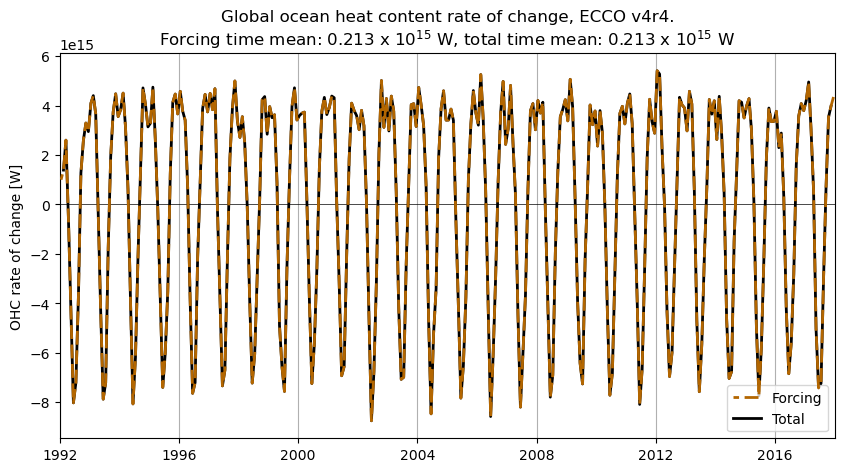

In [7]:
# # pad time_snp with beginning and end times
# time_snp_padded_v4r4 = ds_v4r4.time_snp.pad({'time_snp':(1,1)})
# time_snp_padded_v4r4.data[0] = np.datetime64('1992-01-01T12:00','ns')
# time_snp_padded_v4r4.data[-1] = np.datetime64('2018-01-01','ns')
delta_t_v4r4 = xr.DataArray(np.diff(ds_v4r4.time_snp.values).astype('float64')/(1.e9),dims=['time'])
# time means, excluding first and last months when total tendencies are not available
OHC_change_forcing_globsum_tmean_v4r4 = tmean_compute(OHC_change_forcing_globsum_v4r4[1:-1],\
                                                       delta_t_v4r4[1:-1])
OHC_change_total_globsum_tmean_v4r4 = tmean_compute(OHC_change_total_globsum_v4r4[1:-1],\
                                                     delta_t_v4r4[1:-1])

# plot OHC rate of change, v4r4
fig,ax = plt.subplots(1,1,figsize=(10,5))
ax.plot(ds_v4r4.time.values,OHC_change_forcing_globsum_v4r4.values,\
        color=(.7,.4,0),linewidth=2,linestyle=(3,(5,2)),zorder=10,label='Forcing')
ax.plot(ds_v4r4.time.values,OHC_change_total_globsum_v4r4.values,\
        color=(0,0,0),linewidth=2,label='Total')
ax.axhline(y=0,color=(0,0,0),linewidth=0.5)
ax.grid(axis='x')
ax.set_xlim([np.datetime64('1992-01-01','ns'),np.datetime64('2018-01-01','ns')])
ax.set_ylabel('OHC rate of change [W]')
ax.set_title('Global ocean heat content rate of change, ECCO v4r4.\n'\
             +'Forcing time mean: '+("%.3f" % ((1.e-15)*OHC_change_forcing_globsum_tmean_v4r4))+' x 10$^{15}$ W,'\
             +' total time mean: '+("%.3f" % ((1.e-15)*OHC_change_total_globsum_tmean_v4r4))+' x 10$^{15}$ W')
plt.legend(loc='lower right')
plt.show()

And compare with v4r5...

```{note}
Currently there is a slight mismatch between the v4r5 forcing and total heat fluxes. This is due to missing values in the ice shelf flux NetCDF files, which currently has the fluxes set to zero everywhere. Once these files are corrected this tutorial will be updated.
```

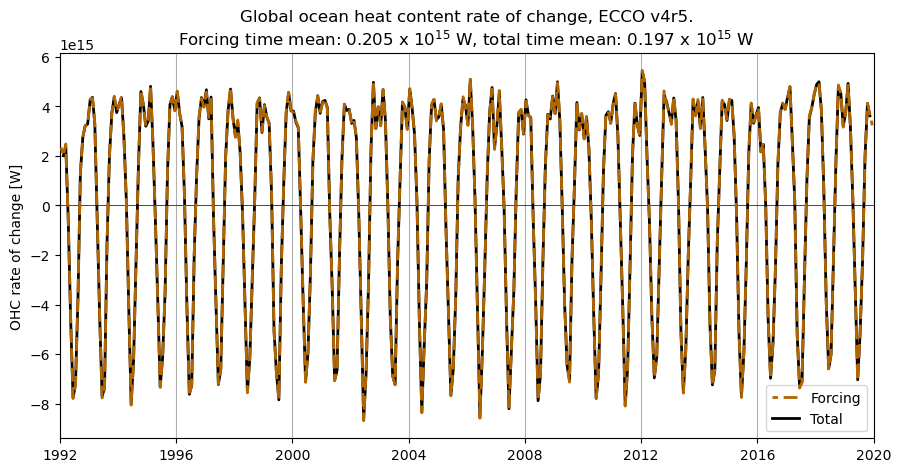

In [8]:
# # pad time_snp with beginning and end times
# time_snp_padded_v4r5 = ds_v4r5.time_snp.pad({'time_snp':(1,1)})
# time_snp_padded_v4r5[0] = np.datetime64('1992-01-01T12:00','ns')
# time_snp_padded_v4r5[-1] = np.datetime64('2020-01-01','ns')
delta_t_v4r5 = xr.DataArray(np.diff(ds_v4r5.time_snp.values).astype('float64')/(1.e9),dims=['time'])
# time means, excluding first and last months when total tendencies are not available
OHC_change_forcing_globsum_tmean_v4r5 = tmean_compute(OHC_change_forcing_globsum_v4r5[1:-1],\
                                                       delta_t_v4r5[1:-1])
OHC_change_total_globsum_tmean_v4r5 = tmean_compute(OHC_change_total_globsum_v4r5[1:-1],\
                                                     delta_t_v4r5[1:-1])

# plot OHC rate of change, v4r5
fig,ax = plt.subplots(1,1,figsize=(10.5,5))
ax.plot(ds_v4r5.time.values,OHC_change_forcing_globsum_v4r5.values,\
        color=(.7,.4,0),linewidth=2,linestyle=(3,(5,2)),zorder=10,label='Forcing')
ax.plot(ds_v4r5.time.values,OHC_change_total_globsum_v4r5.values,\
        color=(0,0,0),linewidth=2,label='Total')
ax.axhline(y=0,color=(0,0,0),linewidth=0.5)
ax.grid(axis='x')
ax.set_xlim([np.datetime64('1992-01-01','ns'),np.datetime64('2020-01-01','ns')])
ax.set_ylabel('OHC rate of change [W]')
ax.set_title('Global ocean heat content rate of change, ECCO v4r5.\n'\
             +'Forcing time mean: '+("%.3f" % ((1.e-15)*OHC_change_forcing_globsum_tmean_v4r5))+' x 10$^{15}$ W,'\
             +' total time mean: '+("%.3f" % ((1.e-15)*OHC_change_total_globsum_tmean_v4r5))+' x 10$^{15}$ W')
plt.legend(loc='lower right')
plt.show()

Now what if we consider the *cumulative* change in global OHC, in each version? Having established that the "forcing" and "total" time series are essentially the same, we can just use the "forcing" time series, which didn't rely on snapshots that are missing at the very beginning and end of the time series.

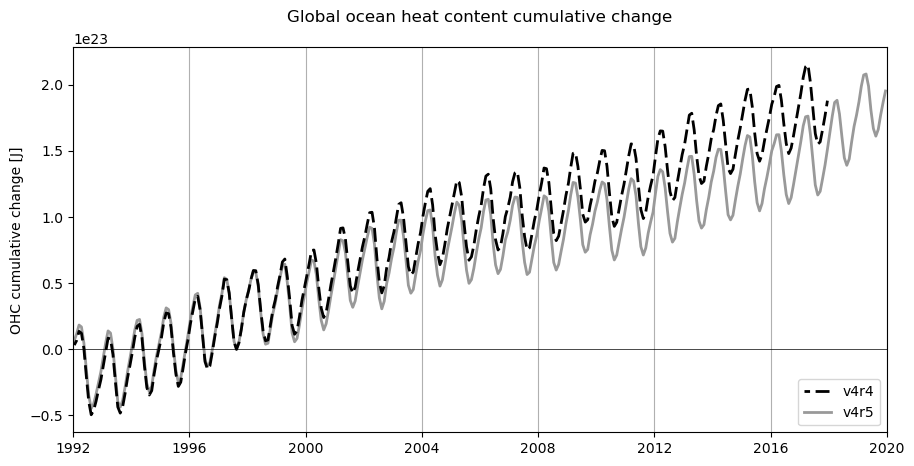

In [9]:
# OHC_cum_change_global_v4r4 = (delta_t_v4r4[1:-1]*OHC_change_forcing_globmean_v4r4[1:-1]).cumsum('time').values
# OHC_cum_change_global_v4r5 = (delta_t_v4r5[1:-1]*OHC_change_forcing_globmean_v4r5[1:-1]).cumsum('time').values
# OHC_cum_change_global_v4r4 = np.pad(OHC_cum_change_global_v4r4,pad_width=(1,1),mode='edge')
# OHC_cum_change_global_v4r5 = np.pad(OHC_cum_change_global_v4r5,pad_width=(1,1),mode='edge')
OHC_cum_change_global_v4r4 = (delta_t_v4r4*OHC_change_forcing_globsum_v4r4).cumsum('time').values
OHC_cum_change_global_v4r5 = (delta_t_v4r5*OHC_change_forcing_globsum_v4r5).cumsum('time').values

# plot OHC rate of change, v4r5
fig,ax = plt.subplots(1,1,figsize=(10.5,5))
ax.plot(ds_v4r4.time.values,OHC_cum_change_global_v4r4,\
        color=(0,0,0),linewidth=2,linestyle=(3,(5,2)),zorder=10,label='v4r4')
ax.plot(ds_v4r5.time.values,OHC_cum_change_global_v4r5,\
        color=(.6,.6,.6),linewidth=2,label='v4r5')
ax.axhline(y=0,color=(0,0,0),linewidth=0.5)
ax.grid(axis='x')
ax.set_xlim([np.datetime64('1992-01-01','ns'),np.datetime64('2020-01-01','ns')])
ax.set_ylabel('OHC cumulative change [J]')
ax.set_title('Global ocean heat content cumulative change\n')
plt.legend(loc='lower right')
plt.show()

You can see that, even though the time mean OHC rate of change in v4r5 is close to that of v4r4, there is a noticeable difference in the cumulative OHC change.

Now let's consider the OHC rate of change and cumulative change--with the seasonal cycle removed. We remove the time mean for each month:

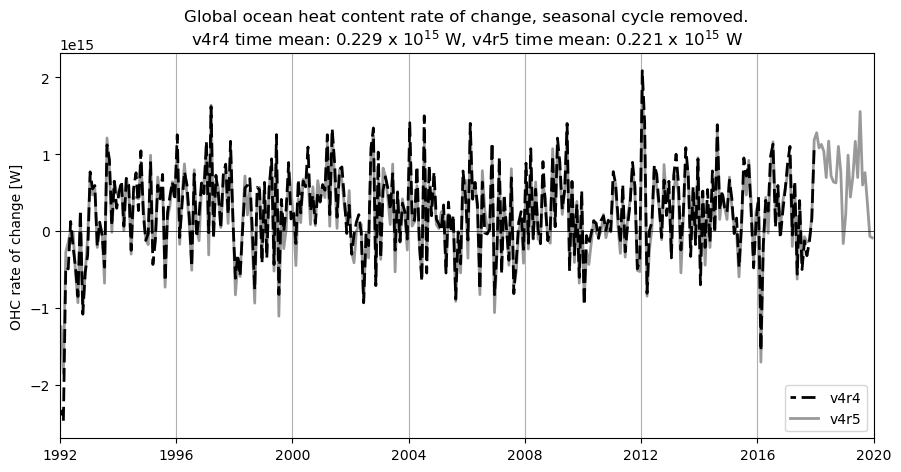

In [17]:
# remove time mean for each month
OHC_change_forcing_globsum_noseas_v4r4 = OHC_change_forcing_globsum_v4r4.groupby("time.month")\
                                        - OHC_change_forcing_globsum_v4r4.groupby("time.month").mean("time")
OHC_change_forcing_globsum_noseas_v4r5 = OHC_change_forcing_globsum_v4r5.groupby("time.month")\
                                        - OHC_change_forcing_globsum_v4r5.groupby("time.month").mean("time")
# add back total time mean
OHC_change_forcing_globsum_noseas_v4r4 += OHC_change_forcing_globsum_v4r4.mean("time")
OHC_change_forcing_globsum_noseas_v4r5 += OHC_change_forcing_globsum_v4r5.mean("time")

# recompute time means using forcing time series, which have first and last month
OHC_change_forcing_globsum_tmean_v4r4 = tmean_compute(OHC_change_forcing_globsum_v4r4,\
                                                       delta_t_v4r4)
OHC_change_forcing_globsum_tmean_v4r5 = tmean_compute(OHC_change_forcing_globsum_v4r5,\
                                                       delta_t_v4r5)

# plot OHC rate of change, no seasonal cycle
fig,ax = plt.subplots(1,1,figsize=(10.5,5))
ax.plot(ds_v4r4.time.values,OHC_change_forcing_globsum_noseas_v4r4.values,\
        color=(0,0,0),linewidth=2,linestyle=(3,(5,2)),zorder=10,label='v4r4')
ax.plot(ds_v4r5.time.values,OHC_change_forcing_globsum_noseas_v4r5.values,\
        color=(.6,.6,.6),linewidth=2,label='v4r5')
ax.axhline(y=0,color=(0,0,0),linewidth=0.5)
ax.grid(axis='x')
ax.set_xlim([np.datetime64('1992-01-01','ns'),np.datetime64('2020-01-01','ns')])
ax.set_ylabel('OHC rate of change [W]')
ax.set_title('Global ocean heat content rate of change, seasonal cycle removed.\n'\
             +'v4r4 time mean: '+("%.3f" % ((1.e-15)*OHC_change_forcing_globsum_tmean_v4r4))+' x 10$^{15}$ W,'\
             +' v4r5 time mean: '+("%.3f" % ((1.e-15)*OHC_change_forcing_globsum_tmean_v4r5))+' x 10$^{15}$ W')
plt.legend(loc='lower right')
plt.show()

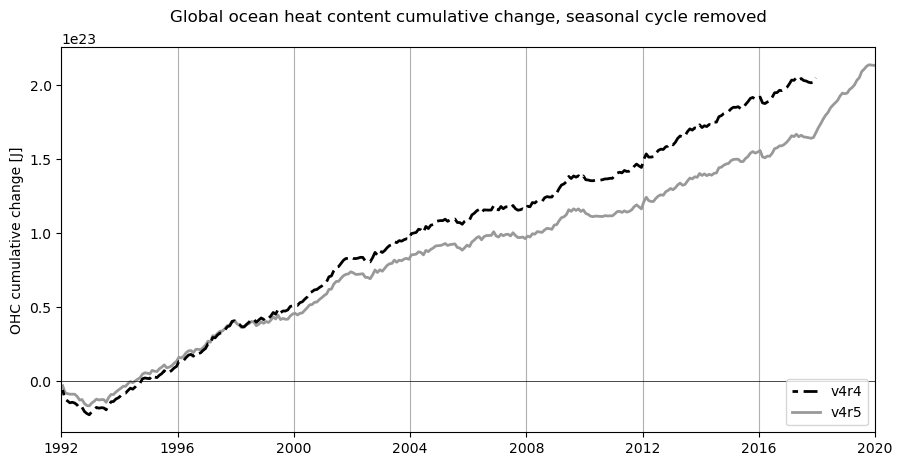

In [18]:
# recompute cumulative OHC change with seasonal cycle removed
OHC_cum_change_global_noseas_v4r4 = (delta_t_v4r4*OHC_change_forcing_globsum_noseas_v4r4).cumsum('time').values
OHC_cum_change_global_noseas_v4r5 = (delta_t_v4r5*OHC_change_forcing_globsum_noseas_v4r5).cumsum('time').values

# plot cumulative OHC change, no seasonal cycle
fig,ax = plt.subplots(1,1,figsize=(10.5,5))
ax.plot(ds_v4r4.time.values,OHC_cum_change_global_noseas_v4r4,\
        color=(0,0,0),linewidth=2,linestyle=(3,(5,2)),zorder=10,label='v4r4')
ax.plot(ds_v4r5.time.values,OHC_cum_change_global_noseas_v4r5,\
        color=(.6,.6,.6),linewidth=2,label='v4r5')
ax.axhline(y=0,color=(0,0,0),linewidth=0.5)
ax.grid(axis='x')
ax.set_xlim([np.datetime64('1992-01-01','ns'),np.datetime64('2020-01-01','ns')])
ax.set_ylabel('OHC cumulative change [J]')
ax.set_title('Global ocean heat content cumulative change, seasonal cycle removed\n')
plt.legend(loc='lower right')
plt.show()

Note that if the global sums of OHC rate of change (ocean heat uptake) are divided by surface area (either the ocean surface area or the Earth's surface area), we would get an effective heat flux in units of W m$^{-2}$. In the ECCO grid, the ocean's surface area is: 

In [19]:
ocean_area_weights = ds_v4r4.hFacC.isel(k=0)*ds_v4r4.rA
ocean_area_sum = ocean_area_weights.sum(['tile','j','i']).compute()
print('Ocean surface area: '+("%.3f" % ((1.e-15)*ocean_area_sum.values))+'e15 m^2')

Ocean surface area: 0.358e15 m^2


In [20]:
area_weights = ds_v4r4.rA
area_sum = area_weights.sum(['tile','j','i']).compute()
print('Earth surface area: '+("%.3f" % ((1.e-15)*area_sum.values))+'e15 m^2')

Earth surface area: 0.510e15 m^2


Dividing by these areas gives us a time mean OHC change per unit area of:

In [22]:
print('v4r4 forcing/ocean area: '+("%.3f" % (OHC_change_forcing_globsum_tmean_v4r4/ocean_area_sum).values)\
      +' W m^-2')
print('v4r5 forcing/ocean area: '+("%.3f" % (OHC_change_forcing_globsum_tmean_v4r5/ocean_area_sum).values)\
      +' W m^-2')
print('v4r4 forcing/Earth area: '+("%.3f" % (OHC_change_forcing_globsum_tmean_v4r4/area_sum).values)\
      +' W m^-2')
print('v4r5 forcing/Earth area: '+("%.3f" % (OHC_change_forcing_globsum_tmean_v4r5/area_sum).values)\
      +' W m^-2')

v4r4 forcing/ocean area: 0.639 W m^-2
v4r5 forcing/ocean area: 0.617 W m^-2
v4r4 forcing/Earth area: 0.449 W m^-2
v4r5 forcing/Earth area: 0.433 W m^-2


Dividing by the Earth's surface area is the most relevant quantity for EEI studies, though dividing by the ocean surface area may be more useful for understanding the ocean-specific energy imbalance. The [von Schuckmann estimates](https://wmo.int/media/news/new-study-shows-earth-energy-imbalance) of the top-of-atmosphere energy imbalance are in the range 0.4-0.8 W m$^{-2}$, so we are at least close to those numbers.

## Components of the heat flux into the ocean

The previous section established that heat fluxes or "forcing" explain the change in the ocean's heat content. Now let's consider the relative contributions of several different types of fluxes. The types that you are probably most familiar with are:

- Radiative fluxes (shortwave + longwave)
- Turbulent fluxes (latent + sensible)

The ECCO variable that contains all of these fluxes into the ocean (from the atmosphere and sea-ice) is `oceQnet`. However, for completeness, we need to consider additional fluxes of heat that are not discussed nearly as much by oceanographers, and which many ocean models neglect:

One is the heat flux associated with the surface freshwater flux `FWflxT`--i.e., from the temperature difference between the water removed from the ocean via evaporation vs. the water restored to the ocean via precipitation and runoff. (Note that this is different from the latent heat flux. Both fluxes are associated with evaporation, but latent heat fluxes result from the phase change of the water, while `FWflxT` results from a temperature change when the water is in the atmosphere or on land.) There is no ECCO variable that quantifies this flux specifically, but the variable `TFLUX` includes the temperature impact of mass fluxes. Hence the difference `TFLUX` - `oceQnet` should reflect the impact of this flux, and this is demonstrated below.

```{note}
The flux `FWflxT` has a negligible impact on temperature locally in a given grid cell, since the water removed or added at the surface has the same temperature as the water already in the grid cell. But when integrated spatially over a large region, especially across a range of latitude bands, the temperature differences between evaporated and precipitated/discharged water become significant.
```


The other heat flux is the geothermal flux, which of course does not occur across the ocean surface but is necessary to close the ocean's heat budget. The geothermal flux is not archived in a dataset like most ECCO variables, but is included as a binary file in the ECCO ancillary output. This file has also been [archived](https://github.com/ECCO-GROUP/ECCO-v4-Python-Tutorial/tree/master/misc) in the ECCOv4 Python tutorial Github repo, and this notebook accesses the file from there.

ECCO makes quantifying these components of the net heat flux into the ocean fairly straightforward, as you can see in the simple function below. Here we compute `FWflxT` explicitly from the surface freshwater flux `oceFWflx` and the surface temperature `THETA` at k=0. Note that we are multiplying the monthly fields of the individual fields, and this may be different from the monthly mean of the *product* of these fields. But you will see that we still get very close to full heat budget closure even with the monthly means.

In [26]:
def G_forcing_components_globmean(ds,version):
    ocean_area_weights = ds.hFacC.isel(k=0)*ds.rA
    ocean_area_sum = ocean_area_weights.sum(['tile','j','i']).compute()
    oceQnet_globmean = ((ocean_area_weights*ds.oceQnet).sum(['tile','j','i'])\
                            /ocean_area_sum).compute()
    c_p = 3994
    FWflxT = c_p*(ds.oceFWflx*(ds.THETA.isel(k=0)))
    FWflxT_globmean = ((ocean_area_weights*FWflxT).sum(['tile','j','i'])\
                            /ocean_area_sum).compute()
    TFLUX_globmean = ((ocean_area_weights*ds.TFLUX).sum(['tile','j','i'])\
                            /ocean_area_sum).compute()
    GEOFLX = geoflx_retrieve(ds)
    geoflx_globmean = ((ocean_area_weights*((GEOFLX.sum('k'))\
                                            *xr.DataArray(np.ones((ds.sizes['time'],)),dims=['time']))).sum(['tile','j','i'])\
                            /ocean_area_sum).compute()
    if version == 'v4r4':
        return oceQnet_globmean,FWflxT_globmean,TFLUX_globmean,geoflx_globmean
    elif version == 'v4r5':
        all_iceshelf_hflux = -ds.SHIhtFlx - (ds.ICFhtFlx.sum('k'))
        iceshelf_globmean = ((ocean_area_weights*all_iceshelf_hflux).sum(['tile','j','i'])\
                                /ocean_area_sum).compute()

        return oceQnet_globmean,FWflxT_globmean,TFLUX_globmean,geoflx_globmean,iceshelf_globmean
        

ratio_ocean_global_area = ((ds_v4r4.hFacC.isel(k=0)*ds_v4r4.rA).sum(['tile','j','i'])\
                            /(ds_v4r4.rA.sum(['tile','j','i']))).values

oceQnet_globmean_v4r4,FWflxT_globmean_v4r4,\
    TFLUX_globmean_v4r4,geoflx_globmean_v4r4 = G_forcing_components_globmean(ds_v4r4,version='v4r4')
oceQnet_globmean_v4r5,FWflxT_globmean_v4r5,\
    TFLUX_globmean_v4r5,geoflx_globmean_v4r5,\
    iceshelf_globmean_v4r5 = G_forcing_components_globmean(ds_v4r5,version='v4r5')

/tmp/ipykernel_2412/1660150111.py:30: DeprecationWarning: Bitwise inversion '~' on bool is deprecated and will be removed in Python 3.16. This returns the bitwise inversion of the underlying int object and is usually not what you expect from negating a bool. Use the 'not' operator for boolean negation or ~int(x) if you really want the bitwise inversion of the underlying int.
  if ~exists(geoflx_filename):


load_binary_array: loading file /home/jovyan/Downloads/geothermalFlux.bin
load_binary_array: data array shape  (1170, 90)
load_binary_array: data array type  >f4
llc_compact_to_faces: dims, llc  (1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  >f4


/tmp/ipykernel_2412/1660150111.py:30: DeprecationWarning: Bitwise inversion '~' on bool is deprecated and will be removed in Python 3.16. This returns the bitwise inversion of the underlying int object and is usually not what you expect from negating a bool. Use the 'not' operator for boolean negation or ~int(x) if you really want the bitwise inversion of the underlying int.
  if ~exists(geoflx_filename):


load_binary_array: loading file /home/jovyan/Downloads/geothermalFlux.bin
load_binary_array: data array shape  (1170, 90)
load_binary_array: data array type  >f4
llc_compact_to_faces: dims, llc  (1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  >f4


### Variability and time mean of heat fluxes

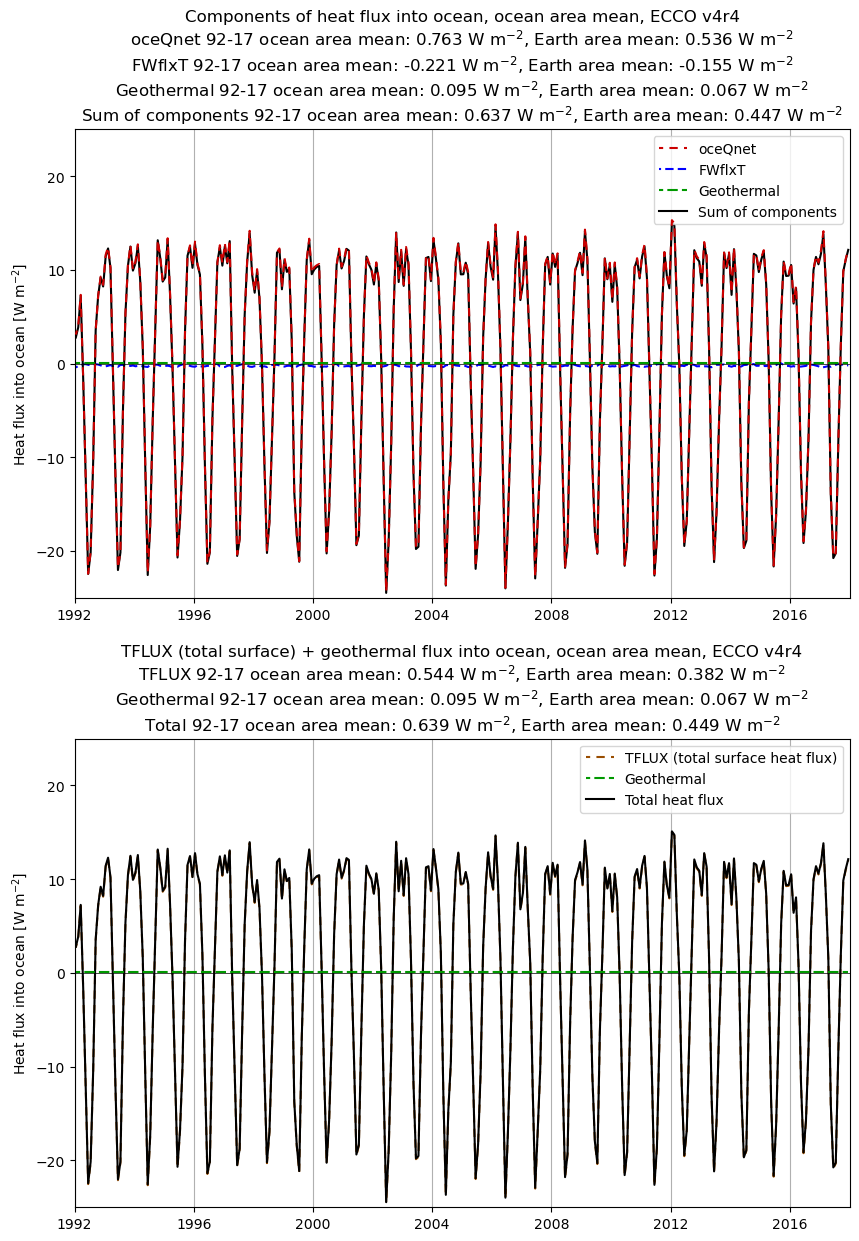

In [34]:
# compute time means
oceQnet_globmean_tmean_v4r4 = tmean_compute(oceQnet_globmean_v4r4,delta_t_v4r4)
FWflxT_globmean_tmean_v4r4 = tmean_compute(FWflxT_globmean_v4r4,delta_t_v4r4)
geoflx_globmean_tmean_v4r4 = tmean_compute(geoflx_globmean_v4r4,delta_t_v4r4)
TFLUX_globmean_tmean_v4r4 = tmean_compute(TFLUX_globmean_v4r4,delta_t_v4r4)

fig,ax = plt.subplots(2,1,figsize=(10,14))
# with oceQnet + FWflxT + geothermal
sum_of_components_v4r4 = oceQnet_globmean_v4r4 + FWflxT_globmean_v4r4 + geoflx_globmean_v4r4
sum_of_components_tmean_v4r4 = oceQnet_globmean_tmean_v4r4 + FWflxT_globmean_tmean_v4r4 + geoflx_globmean_tmean_v4r4
ax[0].plot(ds_v4r4.time.values,oceQnet_globmean_v4r4.values,color=(.8,0,0),linestyle=(2,(4,3)),zorder=20,label='oceQnet')
ax[0].plot(ds_v4r4.time.values,FWflxT_globmean_v4r4.values,color=(0,0,1),linestyle=(3,(4,2)),label='FWflxT')
ax[0].plot(ds_v4r4.time.values,geoflx_globmean_v4r4.values,color=(0,.6,0),linestyle=(3,(5,2)),zorder=100,label='Geothermal')
ax[0].plot(ds_v4r4.time.values,sum_of_components_v4r4.values,color=(0,0,0),label='Sum of components')
ax[0].axhline(y=0,color=(0,0,0),linewidth=0.5)
ax[0].grid(axis='x')
ax[0].set_xlim([np.datetime64('1992-01-01','ns'),np.datetime64('2018-01-01','ns')])
ax[0].set_ylim([-25,25])
ax[0].set_ylabel('Heat flux into ocean [W m$^{-2}$]')
ax[0].set_title('Components of heat flux into ocean, ocean area mean, ECCO v4r4\n'\
             +'oceQnet 92-17 ocean area mean: '+("%.3f" % oceQnet_globmean_tmean_v4r4.values)+' W m$^{-2}$,'\
             +' Earth area mean: '+("%.3f" % (ratio_ocean_global_area*oceQnet_globmean_tmean_v4r4.values))+' W m$^{-2}$\n'\
             +'FWflxT 92-17 ocean area mean: '+("%.3f" % FWflxT_globmean_tmean_v4r4.values)+' W m$^{-2}$,'\
             +' Earth area mean: '+("%.3f" % (ratio_ocean_global_area*FWflxT_globmean_tmean_v4r4.values))+' W m$^{-2}$\n'\
             +'Geothermal 92-17 ocean area mean: '+("%.3f" % geoflx_globmean_tmean_v4r4.values)+' W m$^{-2}$,'\
             +' Earth area mean: '+("%.3f" % (ratio_ocean_global_area*geoflx_globmean_tmean_v4r4.values))+' W m$^{-2}$\n'\
             +'Sum of components 92-17 ocean area mean: '+("%.3f" % sum_of_components_tmean_v4r4.values)+' W m$^{-2}$,'\
             +' Earth area mean: '+("%.3f" % (ratio_ocean_global_area*sum_of_components_tmean_v4r4.values))+' W m$^{-2}$')
ax[0].legend(loc='upper right')
# with TFLUX + geothermal
total_globmean_v4r4 = TFLUX_globmean_v4r4 + geoflx_globmean_v4r4
total_globmean_tmean_v4r4 = TFLUX_globmean_tmean_v4r4 + geoflx_globmean_tmean_v4r4
ax[1].plot(ds_v4r4.time.values,TFLUX_globmean_v4r4.values,color=(.6,.3,0),linestyle=(2,(4,3)),label='TFLUX (total surface heat flux)')
ax[1].plot(ds_v4r4.time.values,geoflx_globmean_v4r4.values,color=(0,.6,0),linestyle=(3,(5,2)),zorder=100,label='Geothermal')
ax[1].plot(ds_v4r4.time.values,total_globmean_v4r4.values,color=(0,0,0),label='Total heat flux')
ax[1].axhline(y=0,color=(0,0,0),linewidth=0.5)
ax[1].grid(axis='x')
ax[1].set_xlim([np.datetime64('1992-01-01','ns'),np.datetime64('2018-01-01','ns')])
ax[1].set_ylim([-25,25])
ax[1].set_ylabel('Heat flux into ocean [W m$^{-2}$]')
ax[1].set_title('TFLUX (total surface) + geothermal flux into ocean, ocean area mean, ECCO v4r4\n'\
             +'TFLUX 92-17 ocean area mean: '+("%.3f" % TFLUX_globmean_tmean_v4r4.values)+' W m$^{-2}$,'\
             +' Earth area mean: '+("%.3f" % (ratio_ocean_global_area*TFLUX_globmean_tmean_v4r4.values))+' W m$^{-2}$\n'\
             +'Geothermal 92-17 ocean area mean: '+("%.3f" % geoflx_globmean_tmean_v4r4.values)+' W m$^{-2}$,'\
             +' Earth area mean: '+("%.3f" % (ratio_ocean_global_area*geoflx_globmean_tmean_v4r4.values))+' W m$^{-2}$\n'\
             +'Total 92-17 ocean area mean: '+("%.3f" % total_globmean_tmean_v4r4.values)+' W m$^{-2}$,'\
             +' Earth area mean: '+("%.3f" % (ratio_ocean_global_area*total_globmean_tmean_v4r4.values))+' W m$^{-2}$')
ax[1].legend(loc='upper right')
# put vertical padding in so that 2 subplots do not overlap
plt.subplots_adjust(hspace=0.3)
plt.show()

Two points to consider about the plots above:

- `oceQnet` (radiative + turbulent heat flux) explains nearly all of the temporal variability in the surface heat flux. However, if we assumed that `oceQnet` contained *all* of the surface heat flux, the estimate of the time mean surface heat flux would be overestimated by ~40%. The relatively steady cooling from evaporated water being warmer than water that is returned to the ocean via precipitation or runoff is a significant part of the global heat budget. This freshwater-associated heat flux (denoted here as `FWflxT`) is distinct from the latent heat flux already contained in `oceQnet`, but like the latent heat flux it moves heat from the ocean to the atmosphere.

- The time mean numbers above show that `oceQnet` + `FWflxT` $\approx$ `TFLUX`, even though `FWflxT` was computed only with monthly means of the freshwater flux and temperature (rather than at each timestep of the model). So this is an encouraging check on our calculations.

Let's consider the first plot above, but with the seasonal cycle removed:

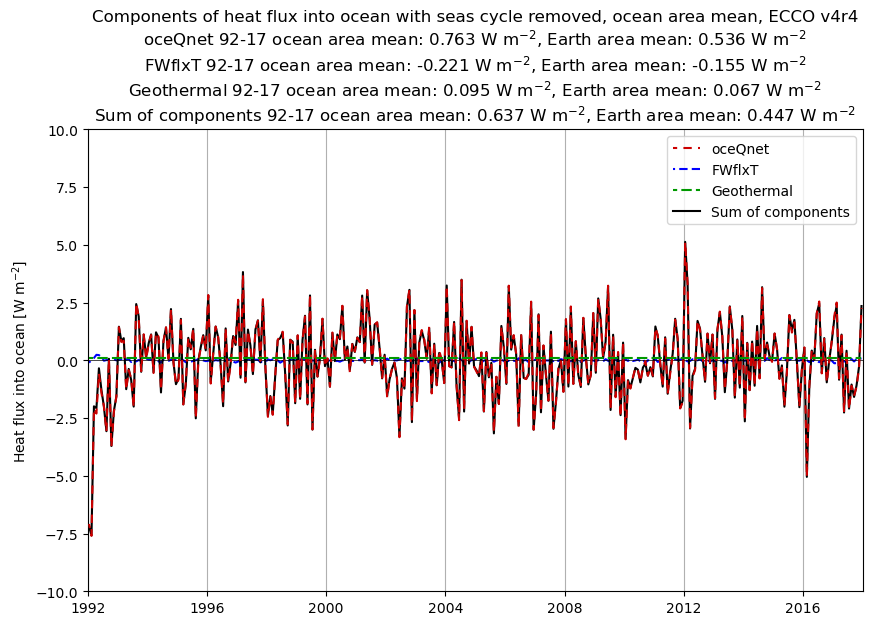

In [40]:
# remove seasonal cycle
def seas_cycle_remove(da_tseries):
    da_tseries_noseas = da_tseries.groupby("time.month")\
                            - da_tseries.groupby("time.month").mean("time")

    return da_tseries_noseas


oceQnet_globmean_noseas_v4r4 = seas_cycle_remove(oceQnet_globmean_v4r4)
FWflxT_globmean_noseas_v4r4 = seas_cycle_remove(FWflxT_globmean_v4r4)
geoflx_globmean_noseas_v4r4 = geoflx_globmean_v4r4 + 0.             # geothermal flux data have no time variation
sum_of_components_noseas_v4r4 = seas_cycle_remove(sum_of_components_v4r4)


fig,ax = plt.subplots(1,1,figsize=(10,6))
ax.plot(ds_v4r4.time.values,oceQnet_globmean_noseas_v4r4.values,color=(.8,0,0),linestyle=(2,(4,3)),zorder=20,label='oceQnet')
ax.plot(ds_v4r4.time.values,FWflxT_globmean_noseas_v4r4.values,color=(0,0,1),linestyle=(3,(4,2)),label='FWflxT')
ax.plot(ds_v4r4.time.values,geoflx_globmean_noseas_v4r4.values,color=(0,.6,0),linestyle=(3,(5,2)),zorder=100,label='Geothermal')
ax.plot(ds_v4r4.time.values,sum_of_components_noseas_v4r4.values,color=(0,0,0),label='Sum of components')
ax.axhline(y=0,color=(0,0,0),linewidth=0.5)
ax.grid(axis='x')
ax.set_xlim([np.datetime64('1992-01-01','ns'),np.datetime64('2018-01-01','ns')])
ax.set_ylim([-10,10])
ax.set_ylabel('Heat flux into ocean [W m$^{-2}$]')
ax.set_title('Components of heat flux into ocean with seas cycle removed, ocean area mean, ECCO v4r4\n'\
             +'oceQnet 92-17 ocean area mean: '+("%.3f" % oceQnet_globmean_tmean_v4r4.values)+' W m$^{-2}$,'\
             +' Earth area mean: '+("%.3f" % (ratio_ocean_global_area*oceQnet_globmean_tmean_v4r4.values))+' W m$^{-2}$\n'\
             +'FWflxT 92-17 ocean area mean: '+("%.3f" % FWflxT_globmean_tmean_v4r4.values)+' W m$^{-2}$,'\
             +' Earth area mean: '+("%.3f" % (ratio_ocean_global_area*FWflxT_globmean_tmean_v4r4.values))+' W m$^{-2}$\n'\
             +'Geothermal 92-17 ocean area mean: '+("%.3f" % geoflx_globmean_tmean_v4r4.values)+' W m$^{-2}$,'\
             +' Earth area mean: '+("%.3f" % (ratio_ocean_global_area*geoflx_globmean_tmean_v4r4.values))+' W m$^{-2}$\n'\
             +'Sum of components 92-17 ocean area mean: '+("%.3f" % sum_of_components_tmean_v4r4.values)+' W m$^{-2}$,'\
             +' Earth area mean: '+("%.3f" % (ratio_ocean_global_area*sum_of_components_tmean_v4r4.values))+' W m$^{-2}$')
plt.legend(loc='upper right')
plt.show()

Now let's plot the ocean heat forcing components from v4r5, with and without the seasonal cycle. We'll also quantify the means during the 1992-2017 period that overlaps with v4r4. Note that v4r5 has fluxes between the ocean and ice shelves that are not included in v4r4.

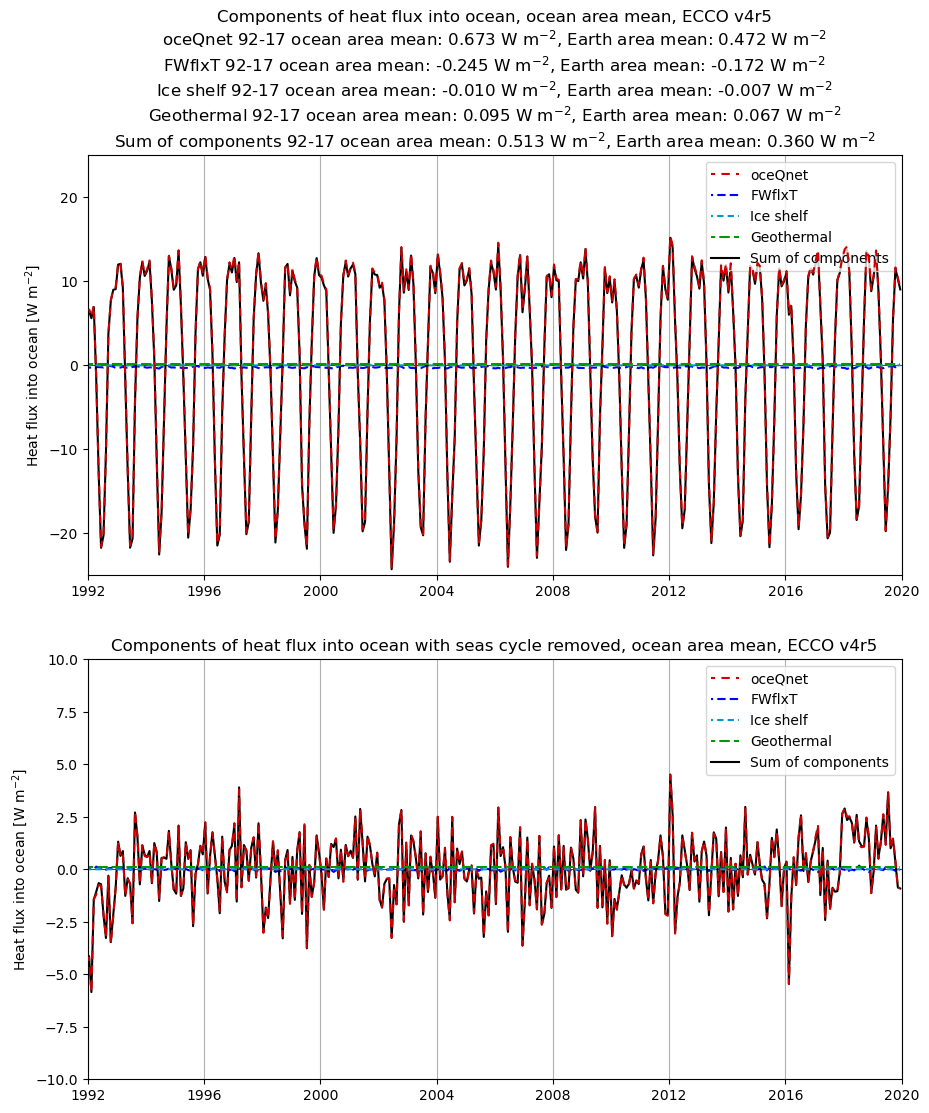

In [43]:
# 1992-2017 time means in v4r5
oceQnet_globmean_tmean_v4r5 = tmean_compute(oceQnet_globmean_v4r5[:-24],delta_t_v4r5[:-24])
FWflxT_globmean_tmean_v4r5 = tmean_compute(FWflxT_globmean_v4r5[:-24],delta_t_v4r5[:-24])
iceshelf_globmean_tmean_v4r5 = tmean_compute(iceshelf_globmean_v4r5[:-24],delta_t_v4r5[:-24])
geoflx_globmean_tmean_v4r5 = tmean_compute(geoflx_globmean_v4r5[:-24],delta_t_v4r5[:-24])

sum_of_components_v4r5 = oceQnet_globmean_v4r5 + FWflxT_globmean_v4r5\
                             + iceshelf_globmean_v4r5 + geoflx_globmean_v4r5
sum_of_components_tmean_v4r5 = tmean_compute(sum_of_components_v4r5[:-24],delta_t_v4r5[:-24])


oceQnet_globmean_noseas_v4r5 = seas_cycle_remove(oceQnet_globmean_v4r5)
FWflxT_globmean_noseas_v4r5 = seas_cycle_remove(FWflxT_globmean_v4r5)
iceshelf_globmean_noseas_v4r5 = seas_cycle_remove(iceshelf_globmean_v4r5)
geoflx_globmean_noseas_v4r5 = geoflx_globmean_v4r5 + 0.
sum_of_components_noseas_v4r5 = seas_cycle_remove(sum_of_components_v4r5)


fig,ax = plt.subplots(2,1,figsize=(10.5,12))
ax[0].plot(ds_v4r5.time.values,oceQnet_globmean_v4r5.values,color=(.8,0,0),linestyle=(2,(4,3)),zorder=20,label='oceQnet')
ax[0].plot(ds_v4r5.time.values,FWflxT_globmean_v4r5.values,color=(0,0,1),linestyle=(3,(4,2)),label='FWflxT')
ax[0].plot(ds_v4r5.time.values,iceshelf_globmean_v4r5.values,color=(0,.6,.8),linestyle=(2,(3,2)),zorder=50,label='Ice shelf')
ax[0].plot(ds_v4r5.time.values,geoflx_globmean_v4r5.values,color=(0,.6,0),linestyle=(3,(5,2)),zorder=100,label='Geothermal')
ax[0].plot(ds_v4r5.time.values,sum_of_components_v4r5.values,color=(0,0,0),label='Sum of components')
ax[0].axhline(y=0,color=(0,0,0),linewidth=0.5)
ax[0].grid(axis='x')
ax[0].set_xlim([np.datetime64('1992-01-01','ns'),np.datetime64('2020-01-01','ns')])
ax[0].set_ylim([-25,25])
ax[0].set_ylabel('Heat flux into ocean [W m$^{-2}$]')
ax[0].set_title('Components of heat flux into ocean, ocean area mean, ECCO v4r5\n'\
             +'oceQnet 92-17 ocean area mean: '+("%.3f" % oceQnet_globmean_tmean_v4r5.values)+' W m$^{-2}$,'\
             +' Earth area mean: '+("%.3f" % (ratio_ocean_global_area*oceQnet_globmean_tmean_v4r5.values))+' W m$^{-2}$\n'\
             +'FWflxT 92-17 ocean area mean: '+("%.3f" % FWflxT_globmean_tmean_v4r5.values)+' W m$^{-2}$,'\
             +' Earth area mean: '+("%.3f" % (ratio_ocean_global_area*FWflxT_globmean_tmean_v4r5.values))+' W m$^{-2}$\n'\
             +'Ice shelf 92-17 ocean area mean: '+("%.3f" % iceshelf_globmean_tmean_v4r5.values)+' W m$^{-2}$,'\
             +' Earth area mean: '+("%.3f" % (ratio_ocean_global_area*iceshelf_globmean_tmean_v4r5.values))+' W m$^{-2}$\n'\
             +'Geothermal 92-17 ocean area mean: '+("%.3f" % geoflx_globmean_tmean_v4r5.values)+' W m$^{-2}$,'\
             +' Earth area mean: '+("%.3f" % (ratio_ocean_global_area*geoflx_globmean_tmean_v4r5.values))+' W m$^{-2}$\n'\
             +'Sum of components 92-17 ocean area mean: '+("%.3f" % sum_of_components_tmean_v4r5.values)+' W m$^{-2}$,'\
             +' Earth area mean: '+("%.3f" % (ratio_ocean_global_area*sum_of_components_tmean_v4r5.values))+' W m$^{-2}$')
ax[0].legend(loc='upper right')
ax[1].plot(ds_v4r5.time.values,oceQnet_globmean_noseas_v4r5.values,color=(.8,0,0),linestyle=(2,(4,3)),zorder=20,label='oceQnet')
ax[1].plot(ds_v4r5.time.values,FWflxT_globmean_noseas_v4r5.values,color=(0,0,1),linestyle=(3,(4,2)),label='FWflxT')
ax[1].plot(ds_v4r5.time.values,iceshelf_globmean_noseas_v4r5.values,color=(0,.6,.8),linestyle=(2,(3,2)),zorder=50,label='Ice shelf')
ax[1].plot(ds_v4r5.time.values,geoflx_globmean_noseas_v4r5.values,color=(0,.6,0),linestyle=(3,(5,2)),zorder=100,label='Geothermal')
ax[1].plot(ds_v4r5.time.values,sum_of_components_noseas_v4r5.values,color=(0,0,0),label='Sum of components')
ax[1].axhline(y=0,color=(0,0,0),linewidth=0.5)
ax[1].grid(axis='x')
ax[1].set_xlim([np.datetime64('1992-01-01','ns'),np.datetime64('2020-01-01','ns')])
ax[1].set_ylim([-10,10])
ax[1].set_ylabel('Heat flux into ocean [W m$^{-2}$]')
ax[1].set_title('Components of heat flux into ocean with seas cycle removed, ocean area mean, ECCO v4r5')
ax[1].legend(loc='upper right')
plt.subplots_adjust(hspace=0.2)
plt.show()

Note that the difference between the v4r4 and v4r5 time means is up to ~20% for the same period (1992-2017), underscoring the challenge of getting accurate estimates of the ocean's energy imbalance.

### Trends in heat fluxes

Presumably at some time in the not-too-distant past (preindustrial era, or even more recently when global greenhouse emissions were lower), the ocean's energy imbalance was lower or even had the sign reversed. Hence we might be interested not only in what the time mean of the imbalance is, but the trend in recent decades. Below we can quantify the trends in each component of the heat flux, keeping in mind that ECCO only goes back to 1992 so it is a relatively short time window to look for an emissions-related trend.

In [44]:
# a general trend computation function that I use frequently
def trend_compute(input_array,axis=-1,delta_dim=1,output_trendline=False):
    """
    Computes linear regression-based trend in NumPy array input_array, along specified axis with interval delta_dim.
    Outputs trend values in reg_trend.
    If output_trendline = True, also outputs trend lines in reg_trendline."""
    
    input_reshaped = np.moveaxis(input_array,axis,0)
    input_shape = input_reshaped.shape
    dim_vec = np.arange(0.,input_shape[0])
    mask = np.asarray(np.logical_and(np.logical_and(~np.isnan(input_reshaped),~np.isinf(input_reshaped)),\
                                      np.abs(input_reshaped) > 1e-10*np.nanmax(np.abs(input_reshaped))))
    dim_vec_tiled = np.moveaxis(np.tile(dim_vec,np.concatenate((input_shape[1:],[1]))),-1,0)
    dim_vec_nomean = dim_vec_tiled - (np.sum(mask*dim_vec_tiled,axis=0)/np.sum(mask,axis=0))
    input_mean = np.nansum(mask*input_reshaped,axis=0,keepdims=True)/np.nansum(mask,axis=0,keepdims=True)
    input_nomean = input_reshaped - input_mean
    reg_num = np.nansum(mask*(dim_vec_nomean*input_nomean),axis=0,keepdims=True)
    reg_denom = np.nansum(mask*(dim_vec_nomean**2),axis=0,keepdims=True)
    reg_trend = (np.moveaxis(reg_num/reg_denom,0,axis))/delta_dim
    if output_trendline == True:
        reg_trendline = np.moveaxis(input_mean,0,axis) + (delta_dim*reg_trend*np.moveaxis(dim_vec_nomean,0,axis))
        return reg_trend,reg_trendline
    else:    
        return reg_trend

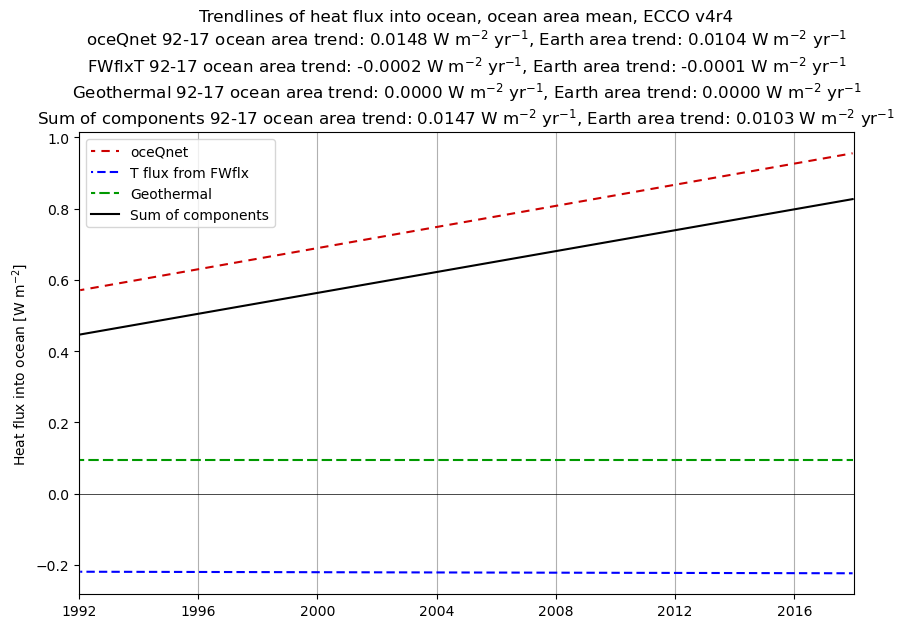

In [46]:
# trends, computed with weights based on month length
trend_normalization = (delta_t_v4r4.sum('time')/len(delta_t_v4r4)).values
oceQnet_globmean_v4r4_trendperyr,oceQnet_globmean_v4r4_trendline = \
            trend_compute((delta_t_v4r4*oceQnet_globmean_v4r4).values,delta_dim=1/12,output_trendline=True)
oceQnet_globmean_v4r4_trendperyr = oceQnet_globmean_v4r4_trendperyr/trend_normalization
oceQnet_globmean_v4r4_trendline = oceQnet_globmean_v4r4_trendline/trend_normalization
FWflxT_globmean_v4r4_trendperyr,FWflxT_globmean_v4r4_trendline = \
            trend_compute((delta_t_v4r4*FWflxT_globmean_v4r4).values,delta_dim=1/12,output_trendline=True)
FWflxT_globmean_v4r4_trendperyr = FWflxT_globmean_v4r4_trendperyr/trend_normalization
FWflxT_globmean_v4r4_trendline = FWflxT_globmean_v4r4_trendline/trend_normalization
geoflx_globmean_v4r4_trendperyr,geoflx_globmean_v4r4_trendline = \
            trend_compute((delta_t_v4r4*geoflx_globmean_v4r4).values,delta_dim=1/12,output_trendline=True)
geoflx_globmean_v4r4_trendperyr = geoflx_globmean_v4r4_trendperyr/trend_normalization
geoflx_globmean_v4r4_trendline = geoflx_globmean_v4r4_trendline/trend_normalization
sum_of_components_v4r4_trendperyr,sum_of_components_v4r4_trendline = \
            trend_compute((delta_t_v4r4*sum_of_components_v4r4).values,delta_dim=1/12,output_trendline=True)
sum_of_components_v4r4_trendperyr = sum_of_components_v4r4_trendperyr/trend_normalization
sum_of_components_v4r4_trendline = sum_of_components_v4r4_trendline/trend_normalization

fig,ax = plt.subplots(1,1,figsize=(10,6))
ax.plot(ds_v4r4.time.values,oceQnet_globmean_v4r4_trendline,\
                color=(.8,0,0),linestyle=(2,(4,3)),zorder=20,label='oceQnet')
ax.plot(ds_v4r4.time.values,FWflxT_globmean_v4r4_trendline,\
                color=(0,0,1),linestyle=(3,(4,2)),label='T flux from FWflx')
ax.plot(ds_v4r4.time.values,geoflx_globmean_v4r4_trendline,\
                color=(0,.6,0),linestyle=(3,(5,2)),zorder=100,label='Geothermal')
ax.plot(ds_v4r4.time.values,sum_of_components_v4r4_trendline,\
                color=(0,0,0),label='Sum of components')
ax.axhline(y=0,color=(0,0,0),linewidth=0.5)
ax.grid(axis='x')
ax.set_xlim([np.datetime64('1992-01-01','ns'),np.datetime64('2018-01-01','ns')])
ax.set_ylabel('Heat flux into ocean [W m$^{-2}$]')
ax.set_title('Trendlines of heat flux into ocean, ocean area mean, ECCO v4r4\n'\
             +'oceQnet 92-17 ocean area trend: '+("%.4f" % oceQnet_globmean_v4r4_trendperyr[0])+' W m$^{-2}$ yr$^{-1}$,'\
             +' Earth area trend: '+("%.4f" % (ratio_ocean_global_area*oceQnet_globmean_v4r4_trendperyr[0]))\
                         +' W m$^{-2}$ yr$^{-1}$\n'\
             +'FWflxT 92-17 ocean area trend: '+("%.4f" % FWflxT_globmean_v4r4_trendperyr[0])+' W m$^{-2}$ yr$^{-1}$,'\
             +' Earth area trend: '+("%.4f" % (ratio_ocean_global_area*FWflxT_globmean_v4r4_trendperyr[0]))\
                         +' W m$^{-2}$ yr$^{-1}$\n'\
             +'Geothermal 92-17 ocean area trend: '+("%.4f" % geoflx_globmean_v4r4_trendperyr[0])+' W m$^{-2}$ yr$^{-1}$,'\
             +' Earth area trend: '+("%.4f" % (ratio_ocean_global_area*geoflx_globmean_v4r4_trendperyr[0]))\
                         +' W m$^{-2}$ yr$^{-1}$\n'\
             +'Sum of components 92-17 ocean area trend: '+("%.4f" % sum_of_components_v4r4_trendperyr[0])+' W m$^{-2}$ yr$^{-1}$,'\
             +' Earth area trend: '+("%.4f" % (ratio_ocean_global_area*sum_of_components_v4r4_trendperyr[0]))\
                         +' W m$^{-2}$ yr$^{-1}$')
plt.legend()
plt.show()

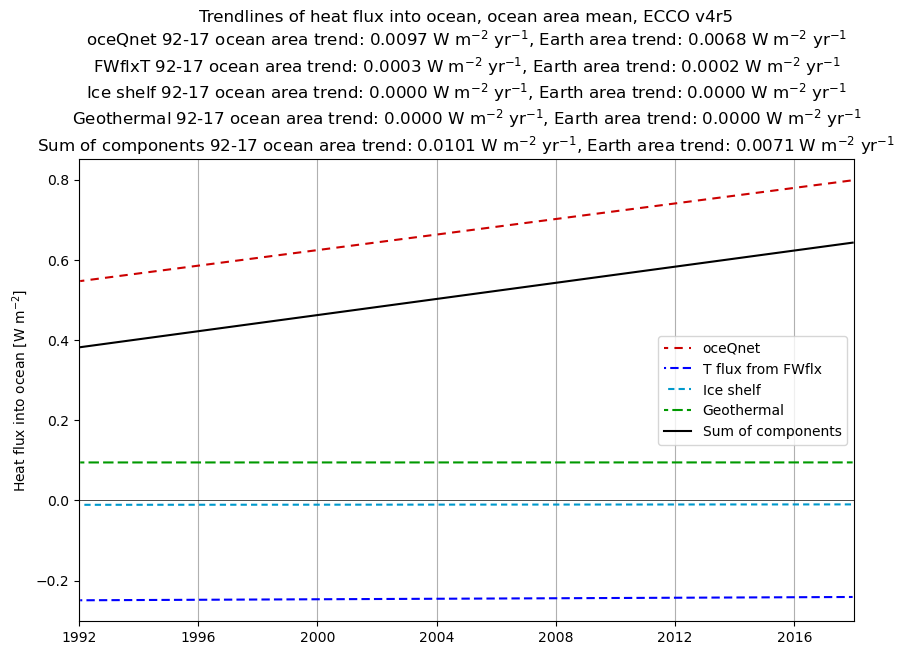

In [47]:
# now for v4r5, 1992-2017

# trends, computed with weights based on month length
trend_normalization = (delta_t_v4r5[:-24].sum('time')/len(delta_t_v4r5[:-24])).values
oceQnet_globmean_v4r5_trendperyr,oceQnet_globmean_v4r5_trendline = \
            trend_compute((delta_t_v4r5*oceQnet_globmean_v4r5).values[:-24],delta_dim=1/12,output_trendline=True)
oceQnet_globmean_v4r5_trendperyr = oceQnet_globmean_v4r5_trendperyr/trend_normalization
oceQnet_globmean_v4r5_trendline = oceQnet_globmean_v4r5_trendline/trend_normalization
FWflxT_globmean_v4r5_trendperyr,FWflxT_globmean_v4r5_trendline = \
            trend_compute((delta_t_v4r5*FWflxT_globmean_v4r5).values[:-24],delta_dim=1/12,output_trendline=True)
FWflxT_globmean_v4r5_trendperyr = FWflxT_globmean_v4r5_trendperyr/trend_normalization
FWflxT_globmean_v4r5_trendline = FWflxT_globmean_v4r5_trendline/trend_normalization
iceshelf_globmean_v4r5_trendperyr,iceshelf_globmean_v4r5_trendline = \
            trend_compute((delta_t_v4r5*iceshelf_globmean_v4r5).values[:-24],delta_dim=1/12,output_trendline=True)
iceshelf_globmean_v4r5_trendperyr = iceshelf_globmean_v4r5_trendperyr/trend_normalization
iceshelf_globmean_v4r5_trendline = iceshelf_globmean_v4r5_trendline/trend_normalization
geoflx_globmean_v4r5_trendperyr,geoflx_globmean_v4r5_trendline = \
            trend_compute((delta_t_v4r5*geoflx_globmean_v4r5).values[:-24],delta_dim=1/12,output_trendline=True)
geoflx_globmean_v4r5_trendperyr = geoflx_globmean_v4r5_trendperyr/trend_normalization
geoflx_globmean_v4r5_trendline = geoflx_globmean_v4r5_trendline/trend_normalization
sum_of_components_v4r5_trendperyr,sum_of_components_v4r5_trendline = \
            trend_compute((delta_t_v4r5*sum_of_components_v4r5).values[:-24],delta_dim=1/12,output_trendline=True)
sum_of_components_v4r5_trendperyr = sum_of_components_v4r5_trendperyr/trend_normalization
sum_of_components_v4r5_trendline = sum_of_components_v4r5_trendline/trend_normalization

fig,ax = plt.subplots(1,1,figsize=(10,6))
ax.plot(ds_v4r5.time[:-24].values,oceQnet_globmean_v4r5_trendline,\
                color=(.8,0,0),linestyle=(2,(4,3)),zorder=20,label='oceQnet')
ax.plot(ds_v4r5.time[:-24].values,FWflxT_globmean_v4r5_trendline,\
                color=(0,0,1),linestyle=(3,(4,2)),label='T flux from FWflx')
ax.plot(ds_v4r5.time[:-24].values,iceshelf_globmean_v4r5_trendline,\
                color=(0,.6,.8),linestyle=(3,(3,2)),label='Ice shelf')
ax.plot(ds_v4r5.time[:-24].values,geoflx_globmean_v4r5_trendline,\
                color=(0,.6,0),linestyle=(3,(5,2)),zorder=100,label='Geothermal')
ax.plot(ds_v4r5.time[:-24].values,sum_of_components_v4r5_trendline,\
                color=(0,0,0),label='Sum of components')
ax.axhline(y=0,color=(0,0,0),linewidth=0.5)
ax.grid(axis='x')
ax.set_xlim([np.datetime64('1992-01-01','ns'),np.datetime64('2018-01-01','ns')])
ax.set_ylabel('Heat flux into ocean [W m$^{-2}$]')
ax.set_title('Trendlines of heat flux into ocean, ocean area mean, ECCO v4r5\n'\
             +'oceQnet 92-17 ocean area trend: '+("%.4f" % oceQnet_globmean_v4r5_trendperyr[0])+' W m$^{-2}$ yr$^{-1}$,'\
             +' Earth area trend: '+("%.4f" % (ratio_ocean_global_area*oceQnet_globmean_v4r5_trendperyr[0]))\
                         +' W m$^{-2}$ yr$^{-1}$\n'\
             +'FWflxT 92-17 ocean area trend: '+("%.4f" % FWflxT_globmean_v4r5_trendperyr[0])+' W m$^{-2}$ yr$^{-1}$,'\
             +' Earth area trend: '+("%.4f" % (ratio_ocean_global_area*FWflxT_globmean_v4r5_trendperyr[0]))\
                         +' W m$^{-2}$ yr$^{-1}$\n'\
             +'Ice shelf 92-17 ocean area trend: '+("%.4f" % iceshelf_globmean_v4r5_trendperyr[0])+' W m$^{-2}$ yr$^{-1}$,'\
             +' Earth area trend: '+("%.4f" % (ratio_ocean_global_area*iceshelf_globmean_v4r5_trendperyr[0]))\
                         +' W m$^{-2}$ yr$^{-1}$\n'\
             +'Geothermal 92-17 ocean area trend: '+("%.4f" % geoflx_globmean_v4r5_trendperyr[0])+' W m$^{-2}$ yr$^{-1}$,'\
             +' Earth area trend: '+("%.4f" % (ratio_ocean_global_area*geoflx_globmean_v4r5_trendperyr[0]))\
                         +' W m$^{-2}$ yr$^{-1}$\n'\
             +'Sum of components 92-17 ocean area trend: '+("%.4f" % sum_of_components_v4r5_trendperyr[0])+' W m$^{-2}$ yr$^{-1}$,'\
             +' Earth area trend: '+("%.4f" % (ratio_ocean_global_area*sum_of_components_v4r5_trendperyr[0]))\
                         +' W m$^{-2}$ yr$^{-1}$')
plt.legend()
plt.show()

In looking at the trendlines from v4r4 and v4r5, we see that:

- `oceQnet` has a substantial trend relative to the time mean value; for example in v4r4, it increases by nearly 0.4 W m$^{-2}$ in the 26-year ECCOv4r4 period. The trend in `FWflxT` is extremely small however, and the trend in `Geothermal` is zero by definition (the geothermal heat flux inputs in ECCO are constant in time). The trend from the ice shelf-ocean heat flux (only included in v4r5) is also negligible.

- As with the time mean, there are large differences in the trends between v4r4 and v4r5...the trend in `oceQnet` is ~50% larger in v4r4 compared to v4r5. Another demonstration of why numerous models and observational datasets are needed to help constrain estimates of the ocean's (and the Earth's) energy imbalance.